In [ ]:
import numpy as np
from numpy.linalg import eigh, pinv, norm
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt

In [ ]:
def gaussian_kernel(X, epsilon):
    """Gaussova jezgra K_ij = exp(-||x_i - x_j||^2 / epsilon)."""
    sq_norms = np.sum(X**2, axis=1)[:, None]
    dist2 = sq_norms + sq_norms.T - 2 * X @ X.T
    K = np.exp(-dist2 / epsilon)
    return K

def inv_sqrt_diag(v):
    """diag(v^{-1/2})"""
    return np.diag(np.power(v, -0.5))

def sym_posdef_inv_sqrt(M, ridge=1e-12):
    """M^{-1/2} za simetričnu pozitivno-definitnu matricu."""
    w, V = eigh(M)
    w = np.maximum(w, ridge)
    return V @ np.diag(1/np.sqrt(w)) @ V.T

def diffusion_kernel(X, epsilon):
    K = gaussian_kernel(X, epsilon)
    q = K.sum(axis=1)
    A = inv_sqrt_diag(q) @ K @ inv_sqrt_diag(q)
    return A, q

# ONM (Orthogonal Nyström Map) iz rada
def onm(A_SS, A_SSk):
    """
    Ulaz:
      A_SS  : A[S,S]
      A_SSk : A[S, S_komplement]
    Izlaz:
      phihat : n×s ortogonalna baza
      Lam    : s×s dijagonalna matrica svojstvenih vrijednosti
    """
    A_SS_inv_sqrt = sym_posdef_inv_sqrt(A_SS)
    C = A_SS + A_SS_inv_sqrt @ (A_SSk @ A_SSk.T) @ A_SS_inv_sqrt
    w, psi = eigh(C)
    idx = np.argsort(w)[::-1]
    w, psi = w[idx], psi[:, idx]
    Lam = np.diag(w)
    Lam_inv_sqrt = np.diag(1/np.sqrt(np.maximum(w, 1e-15)))

    stack = np.vstack([A_SS, A_SSk.T])
    phihat = stack @ A_SS_inv_sqrt @ psi @ Lam_inv_sqrt
    return phihat, Lam

def onm_embedding(Q, phihat, Lam):
    """Φ̂ = Q^{-1/2} φ̂ Λ"""
    return inv_sqrt_diag(Q) @ phihat @ Lam

# μIDM algoritam (Algoritam 5.1)

def muidm(X, epsilon=1.0, mu=1e-3):
    """
    μIDM embedding i rječnik S.
    X : podatci (n×d)
    epsilon : širina Gauss jezgre
    mu : tolerancija pogreške
    """
    n = X.shape[0]
    A, Q = diffusion_kernel(X, epsilon)

    # inicijalni rječnik
    order = np.arange(n)
    S = [order[0]]

    def build(S_idx):
        Sb_idx = [i for i in range(n) if i not in S_idx]
        A_SS  = A[np.ix_(S_idx, S_idx)]
        A_SSb = A[np.ix_(S_idx, Sb_idx)]
        phihat, Lam = onm(A_SS, A_SSb)
        Phi_hat = onm_embedding(Q, phihat, Lam)
        return Phi_hat, S_idx

    Phi_hat, S_idx = build(S)

    for k in range(n-1):
        x_next = order[k+1]
        S_try = S + [x_next]
        Phi_hat_try, S_idx_try = build(S_try)

        # MTM provjera pogreške (Eq. 5.2)
        Phi_S = Phi_hat[S_idx, :]
        Phi_S_inv = pinv(Phi_S, rcond=1e-10)
        Phi_prime_S = Phi_hat_try[S_idx, :]
        T = Phi_S_inv @ Phi_prime_S
        beta = norm(Phi_hat[x_next, :] @ T - Phi_hat_try[x_next, :])

        if beta > mu / 2.0:
            S = S_try
            Phi_hat = Phi_hat_try
            S_idx = S_idx_try

    return Phi_hat,S

Dataset: mobius, n_samples=750, epsilon=1.0, mu=0.0028
Embedding dimenzija: (750, 9)
Veličina rječnika S: 9


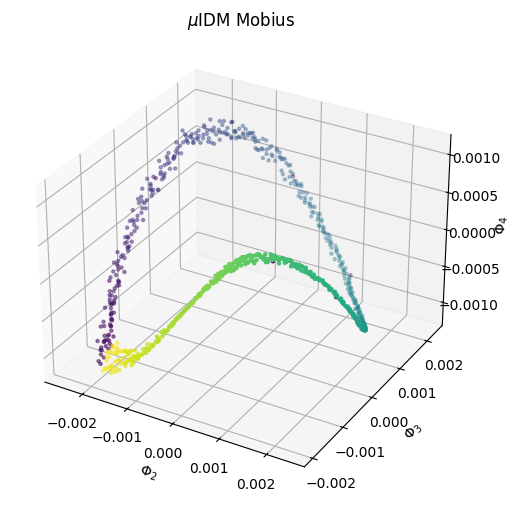

In [ ]:

def make_sphere(n_samples=1000, radius=1.0):
    vec = np.random.normal(size=(n_samples, 3))
    vec /= np.linalg.norm(vec, axis=1)[:, np.newaxis]
    return radius * vec

def make_mobius(n_samples=1000, width=0.3):
    t = np.linspace(0, 2*np.pi, n_samples)

    w = width * (np.random.rand(n_samples) - 0.5) * 2
    x = (1 + (w/2)*np.cos(t/2)) * np.cos(t)
    y = (1 + (w/2)*np.cos(t/2)) * np.sin(t)
    z = (w/2) * np.sin(t/2)
    return np.vstack([x, y, z]).T

def make_dataset(name, n_samples=1000, noise=0.05):
    name = name.lower()
    if name == "swiss":
        X3d, _ = make_swiss_roll(n_samples=n_samples, noise=noise)
    elif name == "sphere":
        X3d = make_sphere(n_samples=n_samples)
    elif name == "mobius":
        X3d = make_mobius(n_samples=n_samples)
    else:
        raise ValueError("Nepoznat skup. Koristi 'swiss', 'sphere' ili 'mobius'.")
    # embed u R^17 dodavanjem nula dimenzija
    zeros = np.zeros((X3d.shape[0], 14))
    return np.hstack([X3d, zeros])


# Parametri za svaki skup

def get_params(dataset_name):


    name = dataset_name.lower()
    if name == "sphere":
        return 750, 1.0,  7.67388e-3#7.673e-3
    elif name == "swiss":
        return 500, 100.0, 2e-2
    elif name == "mobius":
        return 750, 1.0, 2.80e-3
    else:
        raise ValueError("Nepoznat skup. Koristi 'swiss', 'sphere' ili 'mobius'.")


def vizualiziraj_embedding(Phi_hat):
    """
    Vizualizira embedding u 2D ili 3D ovisno o dostupnim svojstvenim vektorima.
    """
    n_vecs = Phi_hat.shape[1]

    if n_vecs >= 4:
        cols = [1,2,3]
    elif n_vecs == 3:
        cols = [0,1,2]
    elif n_vecs == 2:
        # 2D prikaz
        plt.figure(figsize=(6,5))
        plt.scatter(Phi_hat[:,0], Phi_hat[:,1],
                    c=np.linspace(0,1,len(Phi_hat)), cmap='viridis', s=5)
        plt.xlabel('1. svojstveni vektor')
        plt.ylabel('2. svojstveni vektor')
        plt.title('Difuzijska mapa – 2D prikaz')
        plt.show()
        return
    else:
        raise ValueError("Nema dovoljno svojstvenih vektora za vizualizaciju.")

    # 3D prikaz
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Phi_hat[:,1], Phi_hat[:,2], Phi_hat[:,3],
               c=np.linspace(0,1,len(Phi_hat)), cmap='viridis', s=5) # c=Phi_hat[:,1]
    ax.set_xlabel(r'$\Phi_2$'); ax.set_ylabel(r'$\Phi_3$'); ax.set_zlabel(r'$\Phi_4$')
    ax.set_title('$\\mu$IDM Mobius')
    plt.show()


def run_pipeline(dataset_name):
    n_samples, epsilon, mu = get_params(dataset_name)
    print(f"Dataset: {dataset_name}, n_samples={n_samples}, epsilon={epsilon}, mu={mu}")



    X = make_dataset(dataset_name, n_samples=n_samples)


    Phi_hat, S = muidm(X, epsilon=epsilon, mu=mu)

    print("Embedding dimenzija:", Phi_hat.shape)
    print("Veličina rječnika S:", len(S))

    # vizualiziraj
    vizualiziraj_embedding(Phi_hat)

run_pipeline('mobius')
#run_pipeline('sphere')
#run_pipeline('swiss')